In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs
from scipy.interpolate import interp1d

In [2]:
# 读取数据集
def read_images(dataset_dir, target_size=(32, 32)):
    data = []  # 存储图像数据的列表
    labels = []  # 存储标签的列表
    faceshape = [] # 存储图像形状
    for class_dir in os.listdir(dataset_dir):  # 遍历数据集文件夹中的文件夹（每个文件夹代表一个类别）
        class_path = os.path.join(dataset_dir, class_dir)  # 类别文件夹路径
        for file_name in os.listdir(class_path):  # 遍历每个类别文件夹中的图像文件
            file_path = os.path.join(class_path, file_name)  # 图像文件路径
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # 读取灰度图像
            # 缩放图像至目标尺寸
            img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            # 读取第一张灰度图像的大小作为图片形状
            faceshape = img.shape
            data.append(img.flatten())  # 将图像展平并添加到数据列表中
            labels.append(int(class_dir))  # 将类别标签添加到标签列表中
    return np.array(data), np.array(labels).reshape(-1, 1), faceshape  # 返回图像数据和标签

# 训练集和测试集划分
def train_test_split(data, labels, train_test_split_ratio):
    num_samples = data.shape[0]  # 总样本数
    train_samples = int(num_samples * train_test_split_ratio)  # 训练集样本数
    
    # 洗牌算法打乱数据集
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    
    # 划分训练集和测试集
    train_data = data[:train_samples]
    train_labels = labels[:train_samples]
    test_data = data[train_samples:]
    test_labels = labels[train_samples:]
    
    return train_data, train_labels, test_data, test_labels

def test_image(i, train_labels, test_labels, test_data, lpp_eigenfaces, lpp_weight_matrix):
    # 计算测试图像的权重向量
    query = test_data[i]
    query_weight = (lpp_eigenfaces.T @ query.reshape(-1, 1))
    # 计算测试图像与数据集中每个人脸的欧氏距离
    euclidean_distances = np.linalg.norm(lpp_weight_matrix - query_weight, axis=0)
    # 找到最佳匹配的人脸
    best_match_index = np.argmin(euclidean_distances)
    #判断是否匹配正确
    flag = False
    if train_labels[best_match_index] == test_labels[i]:
        flag = True
    else:
        flag = False
    return flag

def ShowEigenface(eigenfaces, faceshape):
    # 显示前16个特征脸
    fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 10))
    for i in range(16):
        axes[i%4][i//4].imshow(eigenfaces[:, i].reshape(faceshape), cmap="gray")
    #print("显示特征脸")
    plt.show()

In [3]:
def PCA(X, n_components):
    # 计算数据矩阵的均值
    mean = np.mean(X, axis=0)
    # 中心化数据矩阵
    X_centered = X - mean
    # 计算数据矩阵的协方差矩阵
    covariance_matrix = np.cov(X_centered, rowvar=False)
    # 计算协方差矩阵的特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    # 对特征向量按特征值从大到小排序
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    # 选取前n_components个特征向量
    principal_components = sorted_eigenvectors[:, :n_components]
    # 返回投影矩阵和均值向量
    return principal_components

In [4]:
def compute_adaptive_neighbors(Data):
    n = Data.shape[1]  # 样本点的数量
    distances = np.sqrt(np.sum((Data.T[:, :, None] - Data.T[:, :, None].T) ** 2, axis=1)) 
    sorted_distances = np.sort(distances, axis=1)  # 对距离矩阵的每一行进行排序
    np.savetxt("sorted_distances.csv", sorted_distances, delimiter=",")
    adaptive_neighbors = np.zeros((n, 1))
    # 对每行距离进行插值和求导
    for i in range(n):
        # 对距离进行插值，生成连续的函数
        f = interp1d(np.arange(n), sorted_distances[i], kind='linear')
        #coefficients = np.polyfit(np.arange(n), sorted_distances[i], deg=5)  # 使用6次多项式拟合
        #f = np.poly1d(coefficients)  # 构建多项式函数
        # 求导
        df = np.gradient(f(np.arange(n)))  # 计算函数的导数
        # 寻找导数为1的位置
        idx = np.where(df <= 1)[0][0]
        # 将索引保存为每个数据点的邻居数量
        adaptive_neighbors[i] = idx
    np.savetxt("adaptive_neighbors.csv", adaptive_neighbors, delimiter=",")
    return adaptive_neighbors, sorted_distances, distances

# 根据adaptive_neighbors中每一行的邻居数量和sorted_distances对每个数据点构建epsilon graph
def adaptive_epsilon_graph(Data):
    adaptive_neighbors, sorted_distances, distances = compute_adaptive_neighbors(Data)
    n = Data.shape[1]  
    adaptive_epsilon_adjacency_matrix = np.zeros((n, n))  
    for i in range(n):
        indices = np.argsort(sorted_distances[i])[:int(adaptive_neighbors[i])]
        adaptive_epsilon_adjacency_matrix[i, indices] = 1
        adaptive_epsilon_adjacency_matrix[indices, i] = 1
    return adaptive_epsilon_adjacency_matrix, distances

def knn_graph(Data, k):
    n = Data.shape[1]  
    knn_adjacency_matrix = np.zeros((n, n))  
    distances = np.sqrt(np.sum((Data.T[:, :, None] - Data.T[:, :, None].T) ** 2, axis=1))
    indices = np.argsort(distances, axis=1)[:, 1:k+1]
    for i in range(n):
        knn_adjacency_matrix[i, indices[i]] = 1
        knn_adjacency_matrix[indices[i], i] = 1
    return knn_adjacency_matrix, distances

def compute_neighborhood_matrix(Data, method, k):
    if method == 'knn':
        knn_adjacency_matrix, distances = knn_graph(Data, k)
        return knn_adjacency_matrix, distances
    elif method == 'adaptive_epsilon':
        adaptive_epsilon_adjacency_matrix, distances = adaptive_epsilon_graph(Data)
        return adaptive_epsilon_adjacency_matrix, distances

def construct_weight_matrix(Data, method, k, t):
    n = Data.shape[1]
    Weight_matrix = np.zeros((n, n))
    adjacency_matrix, distances = compute_neighborhood_matrix(Data, method, k)
    similarity_matrix = np.exp(-distances ** 2 / t)
    i_indices, j_indices = np.where(adjacency_matrix == 1)
    Weight_matrix[i_indices, j_indices] = similarity_matrix[i_indices, j_indices]
    Weight_matrix[j_indices, i_indices] = similarity_matrix[i_indices, j_indices]
    Weight_matrix += np.exp(-distances ** 2 / t)
    return Weight_matrix

def LPP(Data, d, method, k, t):
    Weight_matrix = construct_weight_matrix(Data, method, k, t)
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    Laplacian_matrix = Degree_matrix - Weight_matrix
    objective_value = np.dot(np.dot(Data, Laplacian_matrix), Data.T)  # 计算目标函数
    eigenvalues, eigenvectors = eigs(objective_value, k=d+1)
    sorted_indices = np.argsort(eigenvalues.real)
    selected_indices = sorted_indices[1:d + 1]
    selected_eigenvectors = eigenvectors.real[:, selected_indices]
    return selected_eigenvectors


In [5]:
"""
import os
import numpy as np
import struct

def read_mnist_images(images_file):
    with open(images_file, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows * cols)
    return images

def read_mnist_labels(labels_file):
    with open(labels_file, 'rb') as f:
        magic, num_labels = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

def read_mnist_dataset(dataset_dir):
    train_images_file = os.path.join(dataset_dir, 'train-images.idx3-ubyte')
    train_labels_file = os.path.join(dataset_dir, 'train-labels.idx1-ubyte')
    test_images_file = os.path.join(dataset_dir, 't10k-images.idx3-ubyte')
    test_labels_file = os.path.join(dataset_dir, 't10k-labels.idx1-ubyte')

    train_images = read_mnist_images(train_images_file)
    train_labels = read_mnist_labels(train_labels_file).reshape(-1, 1)
    test_images = read_mnist_images(test_images_file)
    test_labels = read_mnist_labels(test_labels_file).reshape(-1, 1)

    return train_images, train_labels, test_images, test_labels

# 使用示例
train_images, train_labels, test_images, test_labels = read_mnist_dataset("MNIST_ORG")
print("train_images.shape:", train_images.shape)
print("train_labels.shape:", train_labels.shape)
print("test_images.shape:", test_images.shape)
print("test_labels.shape:", test_labels.shape)
"""


'\nimport os\nimport numpy as np\nimport struct\n\ndef read_mnist_images(images_file):\n    with open(images_file, \'rb\') as f:\n        magic, num_images, rows, cols = struct.unpack(\'>IIII\', f.read(16))\n        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows * cols)\n    return images\n\ndef read_mnist_labels(labels_file):\n    with open(labels_file, \'rb\') as f:\n        magic, num_labels = struct.unpack(\'>II\', f.read(8))\n        labels = np.fromfile(f, dtype=np.uint8)\n    return labels\n\ndef read_mnist_dataset(dataset_dir):\n    train_images_file = os.path.join(dataset_dir, \'train-images.idx3-ubyte\')\n    train_labels_file = os.path.join(dataset_dir, \'train-labels.idx1-ubyte\')\n    test_images_file = os.path.join(dataset_dir, \'t10k-images.idx3-ubyte\')\n    test_labels_file = os.path.join(dataset_dir, \'t10k-labels.idx1-ubyte\')\n\n    train_images = read_mnist_images(train_images_file)\n    train_labels = read_mnist_labels(train_labels_file).reshape(

In [6]:
import os
import numpy as np
import struct

def read_mnist_dataset(dataset_dir, fraction=0.2):
    def read_images(images_file, num_images, rows, cols):
        with open(images_file, 'rb') as f:
            magic, total_images = struct.unpack('>II', f.read(8))
            images = np.fromfile(f, dtype=np.uint8, count=num_images * rows * cols)
            images = images.reshape(num_images, rows * cols)
        return images

    def read_labels(labels_file, num_labels):
        with open(labels_file, 'rb') as f:
            magic, total_labels = struct.unpack('>II', f.read(8))
            labels = np.fromfile(f, dtype=np.uint8, count=num_labels)
        return labels

    train_images_file = os.path.join(dataset_dir, 'train-images.idx3-ubyte')
    train_labels_file = os.path.join(dataset_dir, 'train-labels.idx1-ubyte')
    test_images_file = os.path.join(dataset_dir, 't10k-images.idx3-ubyte')
    test_labels_file = os.path.join(dataset_dir, 't10k-labels.idx1-ubyte')

    # 获取数据集的原始数量和图像大小
    with open(train_images_file, 'rb') as f:
        magic, total_train_images, rows, cols = struct.unpack('>IIII', f.read(16))
    with open(test_images_file, 'rb') as f:
        magic, total_test_images, rows, cols = struct.unpack('>IIII', f.read(16))

    # 计算要读取的数量
    num_train_images = int(total_train_images * fraction)
    num_test_images = int(total_test_images * fraction)

    # 读取数据集
    train_images = read_images(train_images_file, num_train_images, rows, cols)
    train_labels = read_labels(train_labels_file, num_train_images).reshape(-1, 1)
    test_images = read_images(test_images_file, num_test_images, rows, cols)
    test_labels = read_labels(test_labels_file, num_test_images).reshape(-1, 1)

    return train_images, train_labels, test_images, test_labels, (rows, cols)

"""
# 使用示例
train_images, train_labels, test_images, test_labels = read_mnist_dataset("MNIST_ORG", fraction=0.2)
print("train_images.shape:", train_images.shape)
print("train_labels.shape:", train_labels.shape)
print("test_images.shape:", test_images.shape)
print("test_labels.shape:", test_labels.shape)
"""


'\n# 使用示例\ntrain_images, train_labels, test_images, test_labels = read_mnist_dataset("MNIST_ORG", fraction=0.2)\nprint("train_images.shape:", train_images.shape)\nprint("train_labels.shape:", train_labels.shape)\nprint("test_images.shape:", test_images.shape)\nprint("test_labels.shape:", test_labels.shape)\n'

In [7]:
import os
from os import path
import numpy as np
import cv2

def read_mini_minst_images(dataset_dir, target_size=None):
    train_data = []  # 存储训练图像数据的列表
    train_labels = []  # 存储训练标签的列表
    test_data = []  # 存储测试图像数据的列表
    test_labels = []  # 存储测试标签的列表
    faceshape = []  # 存储图像形状

    # 读取训练集
    for class_dir in range(10):  # 遍历10个类别文件夹
        class_path = path.join(dataset_dir, 'Reduced Training data', str(class_dir))  # 类别文件夹路径
        for file_name in os.listdir(class_path):  # 遍历每个类别文件夹中的图像文件
            file_path = path.join(class_path, file_name)  # 图像文件路径
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # 读取灰度图像
            # 如果指定了目标尺寸，则缩放图像
            if target_size is not None:
                img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            # 读取第一张灰度图像的大小作为图片形状
            if not faceshape:
                faceshape = img.shape
            train_data.append(img.flatten())  # 将图像展平并添加到训练数据列表中
            train_labels.append(int(class_dir))  # 将类别标签添加到训练标签列表中

    # 读取测试集
    for class_dir in range(10):  # 遍历10个类别文件夹
        class_path = path.join(dataset_dir, 'Reduced Testing data', str(class_dir))  # 类别文件夹路径
        for file_name in os.listdir(class_path):  # 遍历每个类别文件夹中的图像文件
            file_path = path.join(class_path, file_name)  # 图像文件路径
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # 读取灰度图像
            # 如果指定了目标尺寸，则缩放图像
            if target_size is not None:
                img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            test_data.append(img.flatten())  # 将图像展平并添加到测试数据列表中
            test_labels.append(int(class_dir))  # 将类别标签添加到测试标签列表中

    # 将列表转换为numpy数组并返回
    train_images = np.array(train_data)
    train_labels = np.array(train_labels).reshape(-1, 1)
    test_images = np.array(test_data)
    test_labels = np.array(test_labels).reshape(-1, 1)

    return train_images, train_labels, test_images, test_labels, faceshape


data shape: (1797, 64)
target shape: (1797,)


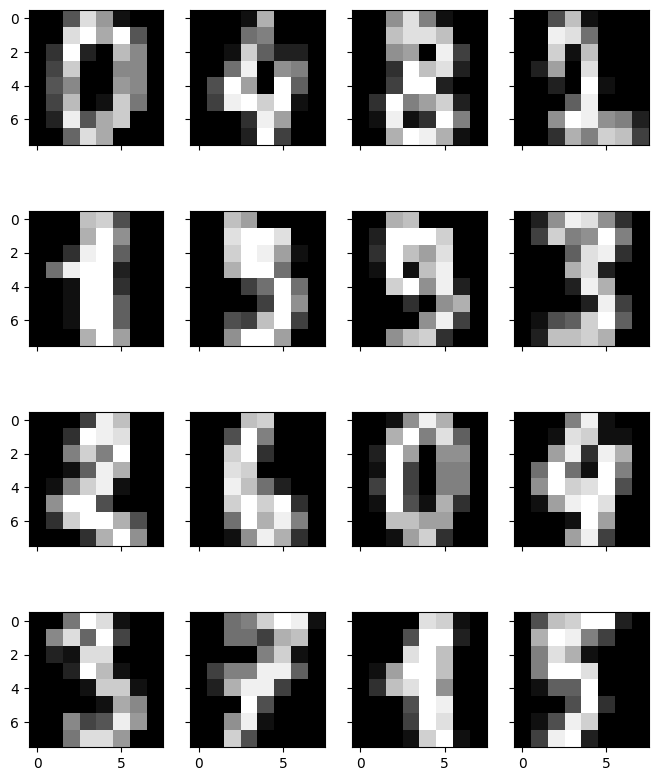

In [8]:
from sklearn.datasets import load_digits
digits = load_digits()
data = digits.data
target = digits.target
images = digits.images
print("data shape:", data.shape)
print("target shape:", target.shape)
faceshape = (8, 8)
# 输出16张images
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 10))
for i in range(16):
    axes[i%4][i//4].imshow(images[i], cmap="gray")
plt.show()

In [9]:
"""
faces, classes, faceshape = read_images("ORL")  # 读取图像数据和标签
train_data, train_labels, test_data, test_labels = train_test_split(faces, classes, 0.7)  # 划分训练集和测试集
d = 70
threshold = 0.5
t = 100000
method = 'knn'
train_data = train_data.T
overall_mean = np.mean(train_data , axis=1).reshape(-1, 1)
lpp_eigenfaces = LPP(train_data, d, method, threshold, t)
lpp_weight_matrix = lpp_eigenfaces.T @ (train_data-overall_mean)

# 单次识别率统计
wrong_times = 0
right_times = 0
for i in range(test_data.shape[0]):
    flag = test_image(i, train_labels, test_labels, test_data, lpp_eigenfaces, lpp_weight_matrix)
    if flag:
                right_times += 1
    else:
        wrong_times += 1
rate = right_times / test_data.shape[0]
print(f"Recognition Rate: {rate}")
#ShowEigenface(lpp_eigenfaces, faceshape)
"""

# 求平均识别率
times = 1
rates = []
for i in range(times):
    d = 30
    t = 100000
    k = 5
    #method = "knn"
    method = "adaptive_epsilon"
    faces, classes, faceshape = read_images("ORL")  # 读取图像数据和标签
    train_data, train_labels, test_data, test_labels = train_test_split(faces, classes, 0.7)  # 划分ORL训练集和测试集
    #train_data, train_labels, test_data, test_labels = train_test_split(data, target, 0.2)
    print("train_data shape:", train_data.shape)
    print("train_labels shape:", train_labels.shape)
    print("test_data shape:", test_data.shape)
    print("test_labels shape:", test_labels.shape)
    #train_data, train_labels, test_data, test_labels, faceshape  = read_mnist_dataset("MNIST_ORG", fraction=0.01)
    #train_data, train_labels, test_data, test_labels, faceshape  = read_mini_minst_images("Reduced MNIST Data", target_size=None)
    data = train_data.T
    lpp_eigenvectors = LPP(data, d, method, k, t)
    lpp_weight_matrix = lpp_eigenvectors.T @ data
    wrong_times = 0
    right_times = 0
    for i in range(test_data.shape[0]):
        flag = test_image(i, train_labels, test_labels, test_data, lpp_eigenvectors, lpp_weight_matrix)
        if flag:
                    right_times += 1
        else:
            wrong_times += 1
    rate = right_times / test_data.shape[0]
    rates.append(rate)
print(f"Average Recognition Rate: {np.mean(rates)}")
print(rates)

train_data shape: (280, 1024)
train_labels shape: (280, 1)
test_data shape: (120, 1024)
test_labels shape: (120, 1)
Average Recognition Rate: 0.975
[0.975]


C:\Users\Tony-Huang\AppData\Local\Temp\ipykernel_22004\1532361492.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  indices = np.argsort(sorted_distances[i])[:int(adaptive_neighbors[i])]


In [10]:
#ShowEigenface(lpp_eigenvectors, faceshape)